In [ ]:
!pip install openpyxl
!pip install scikit-learn

In [ ]:
!pip install googlemaps
import googlemaps

In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Iter4').getOrCreate()

from pyspark.sql.functions import col, count
from pyspark.sql.functions import sum as spark_sum
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import (RandomForestClassifier, GBTClassifier, DecisionTreeClassifier)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import statsmodels.api as sm
import seaborn as sns

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/20 18:26:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# 1 Business understanding

Find out the allocation of charging stations, what makes a region to build
more charging stations, how many more stations should there be in the future
when the regions attributes change, e.g. population
# 2 Data understanding

## 2.1 Load Dataset

In [ ]:
file1 = "IEA-EV-data.csv"
file2 = "EV_Roam_charging_stations.csv"
file3 = "NZ_Public_EV_Charger_Data.csv"
file4 = "charger-data.csv"
file5 = "traffic_counts.csv"
file6 = "subnational-population-projections.xlsx"

In [36]:
# world EV amounts
df_EV = spark.read.csv(file1, header=True)

In [4]:
# charging station and locations
df_cha = spark.read.csv(file2, header=True)
df_cha2 = spark.read.csv(file3, header=True)

In [5]:
# yearly highway traffic by region
df_tra = spark.read.csv(file5, header=True)

In [6]:
# NZ regional population and age
df_pop = pd.read_excel(file6, sheet_name="Table 1")
df_age = pd.read_excel(file6, sheet_name="Table 4")

## 2.2 Describe the data

In [7]:
df_EV.show(5)
df_EV.printSchema()
df_EV.count(), len(df_EV.columns)

+---------+----------+--------------+----+----------+----+--------+--------------------+
|   region|  category|     parameter|mode|powertrain|year|    unit|               value|
+---------+----------+--------------+----+----------+----+--------+--------------------+
|Australia|Historical|      EV stock|Cars|       BEV|2011|Vehicles|                  49|
|Australia|Historical|EV sales share|Cars|        EV|2011| percent|0.006500000134110451|
|Australia|Historical|EV stock share|Cars|        EV|2011| percent|0.000460000010207...|
|Australia|Historical|      EV sales|Cars|       BEV|2011|Vehicles|                  49|
|Australia|Historical|      EV sales|Cars|       BEV|2012|Vehicles|                 170|
+---------+----------+--------------+----+----------+----+--------+--------------------+
only showing top 5 rows

root
 |-- region: string (nullable = true)
 |-- category: string (nullable = true)
 |-- parameter: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- powertrai

(9542, 8)

In [8]:
df_cha.show(1)
df_cha.printSchema()
df_cha.count(), len(df_cha.columns)

+------------+------------+--------+-----------+--------------------+--------------------+--------------------+---------+------------+--------------+------------+--------------------+---------+----------+-----------+--------------------+------------------+--------------------+---------------+--------------------+
|           X|           Y|OBJECTID|       name|            operator|               owner|             address|is24Hours|carParkCount|hasCarparkCost|maxTimeLimit|hasTouristAttraction| latitude| longitude|currentType|dateFirstOperational|numberOfConnectors|      connectorsList|hasChargingCost|            GlobalID|
+------------+------------+--------+-----------+--------------------+--------------------+--------------------+---------+------------+--------------+------------+--------------------+---------+----------+-----------+--------------------+------------------+--------------------+---------------+--------------------+
|1366541.2354|5153202.1642|  109092|YHA MT COOK|MERIDIA

(786, 20)

In [9]:
df_cha2.show(1)
df_cha2.printSchema()
df_cha2.count(), len(df_cha2.columns)

+----------+----------+------------+------------+--------+---+--------------------+-------------+---------------+--------------------+----------+-----------+-----------+
|    Region|  Locality|    Operator|       Owner|DC or AC| kW|          Connectors|Num_installed|Num_in_progress|             Address|      Long|        Lat|EECA funded|
+----------+----------+------------+------------+--------+---+--------------------+-------------+---------------+--------------------+----------+-----------+-----------+
|Wellington|Wellington|ChargeNet NZ|ChargeNet NZ|      DC| 25|DC 50 kW CHAdeMO,...|            1|              0|1 Stevens Grove, ...|174.904344|-41.2111426|        Yes|
+----------+----------+------------+------------+--------+---+--------------------+-------------+---------------+--------------------+----------+-----------+-----------+
only showing top 1 row

root
 |-- Region: string (nullable = true)
 |-- Locality: string (nullable = true)
 |-- Operator: string (nullable = true)
 |-

(278, 13)

df_cha2 is short, has fewer variables, and thus not to be used.

In [10]:
df_pop.head(2)

,Table 1,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,Projected population of regional council areas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018(base)–2048 update,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_age.head(2)

,Table 4,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,Projected population age structure and compone...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Regional council areas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


df_pop and df_age need cleaning

In [12]:
df_tra.show(5)
df_tra.printSchema()
df_tra.count(), len(df_tra.columns)

+---------+-------------+------------------+
|startDate|   regionName|      trafficCount|
+---------+-------------+------------------+
|     2018|     Auckland| 7869.100052426216|
|     2018|Bay of Plenty|2888.0273934783277|
|     2018|   Canterbury|3240.1993288997596|
|     2018|     Gisborne|1061.3205895900508|
|     2018|   Hawkes Bay|2603.7595728737356|
+---------+-------------+------------------+
only showing top 5 rows

root
 |-- startDate: string (nullable = true)
 |-- regionName: string (nullable = true)
 |-- trafficCount: string (nullable = true)



(96, 3)

## 2.3 Explore Data
### df_EV

In [13]:
df_EV = df_EV.filter(col("region") == "New Zealand")
df_EV.groupBy("category").agg(count("*").alias("count")).show()
df_EV.groupBy("year").agg(count("*").alias("count")).show()

+----------+-----+
|  category|count|
+----------+-----+
|Historical|  170|
+----------+-----+

+----+-----+
|year|count|
+----+-----+
|2016|    8|
|2012|   10|
|2020|   22|
|2019|   20|
|2017|   11|
|2014|    8|
|2013|    8|
|2018|   12|
|2011|   10|
|2022|   23|
|2021|   24|
|2015|    8|
|2010|    6|
+----+-----+



All data for NZ is historical record, 2010 to 2022.

In [14]:
df_EV.groupBy("mode").agg(count("*").alias("count")).show()
df_EV.filter(col("mode") == "EV").show(2)
df_EV.filter(col("mode") == "EV").groupBy("parameter").agg(count("*").alias("count")).show()
df_EV = df_EV.filter(col("mode") != "EV")

+------+-----+
|  mode|count|
+------+-----+
|    EV|   11|
| Buses|   45|
|  Cars|   76|
|Trucks|   16|
|  Vans|   22|
+------+-----+

+-----------+----------+------------------+----+--------------------+----+---------------+-----+
|     region|  category|         parameter|mode|          powertrain|year|           unit|value|
+-----------+----------+------------------+----+--------------------+----+---------------+-----+
|New Zealand|Historical|EV charging points|  EV|Publicly availabl...|2017|charging points|  100|
|New Zealand|Historical|EV charging points|  EV|Publicly availabl...|2018|charging points|  200|
+-----------+----------+------------------+----+--------------------+----+---------------+-----+
only showing top 2 rows

+------------------+-----+
|         parameter|count|
+------------------+-----+
|EV charging points|   11|
+------------------+-----+



When 'mode' is 'EV', the record is about charging points.

In [15]:
df_EV.groupBy("parameter").agg(count("*").alias("count")).show()
df_EV.filter(col("parameter") == "EV stock share").groupBy("powertrain").agg(count("*").alias("count")).show()
df_EV.filter(col("parameter") == "EV sales").groupBy("powertrain").agg(count("*").alias("count")).show()
df_EV.filter(col("parameter") == "EV sales share").groupBy("powertrain").agg(count("*").alias("count")).show()
df_EV.filter(col("parameter") == "EV stock").groupBy("powertrain").agg(count("*").alias("count")).show()

+--------------+-----+
|     parameter|count|
+--------------+-----+
|EV stock share|   34|
|      EV sales|   45|
|EV sales share|   29|
|      EV stock|   51|
+--------------+-----+

+----------+-----+
|powertrain|count|
+----------+-----+
|        EV|   34|
+----------+-----+

+----------+-----+
|powertrain|count|
+----------+-----+
|      PHEV|   16|
|       BEV|   29|
+----------+-----+

+----------+-----+
|powertrain|count|
+----------+-----+
|        EV|   29|
+----------+-----+

+----------+-----+
|powertrain|count|
+----------+-----+
|      PHEV|   17|
|       BEV|   34|
+----------+-----+



There are corresponding relations between 'parameter' and 'powertrain'.

### df_cha

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

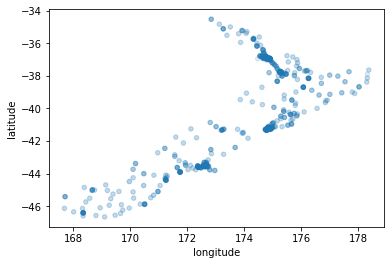

In [11]:
df_cha2 = df_cha.select("longitude", "latitude", "numberOfConnectors").toPandas()
df_cha2["longitude"] = df_cha2["longitude"].astype(float)
df_cha2["latitude"] = df_cha2["latitude"].astype(float)
df_cha2["numberOfConnectors"] = df_cha2["numberOfConnectors"].astype(int)
max_alpha = max(df_cha2["numberOfConnectors"])
df_cha2.plot.scatter(x="longitude", y="latitude", alpha=df_cha2["numberOfConnectors"]/max_alpha)

The geographic distribution of charging stations. Each point's opacity represents the number of connectors, an indication of supply capacity.

-1.6615776081424936

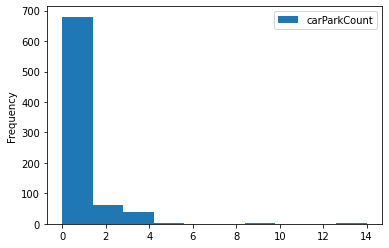

In [21]:
df_cha.select("carParkCount").toPandas().astype(int).plot.hist()
result = df_cha.select(spark_sum(col("carParkCount") - col("numberOfConnectors")).alias("sum_diff")).collect()
result[0]["sum_diff"] / df_cha.count()

There are more charging connectors than parking lots.

In [22]:
df_cha.groupBy("is24Hours").agg(count("*").alias("count")).show()
df_cha.groupBy("hasCarparkCost").agg(count("*").alias("count")).show()
df_cha.groupBy("maxTimeLimit").agg(count("*").alias("count")).show()
df_cha.groupBy("hasTouristAttraction").agg(count("*").alias("count")).show()
df_cha.groupBy("currentType").agg(count("*").alias("count")).show()
df_cha.groupBy("numberOfConnectors").agg(count("*").alias("count")).show()
df_cha.groupBy("hasChargingCost").agg(count("*").alias("count")).show()

+---------+-----+
|is24Hours|count|
+---------+-----+
|    False|   38|
|     True|  748|
+---------+-----+

+--------------+-----+
|hasCarparkCost|count|
+--------------+-----+
|         False|  713|
|          True|   73|
+--------------+-----+

+------------+-----+
|maxTimeLimit|count|
+------------+-----+
|        None|    6|
|         120|   66|
|          90|    2|
|    No Limit|   16|
|         240|    4|
|         180|   10|
|   Unlimited|  682|
+------------+-----+

+--------------------+-----+
|hasTouristAttraction|count|
+--------------------+-----+
|               False|  782|
|                True|    4|
+--------------------+-----+

+-----------+-----+
|currentType|count|
+-----------+-----+
|         DC|  522|
|      Mixed|   70|
|         AC|  194|
+-----------+-----+

+------------------+-----+
|numberOfConnectors|count|
+------------------+-----+
|                 7|    1|
|                 3|   56|
|                 8|   14|
|                 5|   16|
|              

'maxTimeLimit' needs cleaning.
### df_tra

In [24]:
df_tra.groupBy("regionName").agg(count("*").alias("count")).show()

+------------------+-----+
|        regionName|count|
+------------------+-----+
|        Wellington|    6|
|          Auckland|    6|
|          Gisborne|    6|
|         Southland|    6|
|        Hawkes Bay|    6|
|           Waikato|    6|
|          Taranaki|    6|
|             Otago|    6|
|     Bay of Plenty|    6|
|        Canterbury|    6|
|            Nelson|    6|
|        West Coast|    6|
|Manawatu-Whanganui|    6|
|         Northland|    6|
|            Tasman|    6|
|       Marlborough|    6|
+------------------+-----+



There are 16 regions.\
Below are average daily traffic by region in the years.

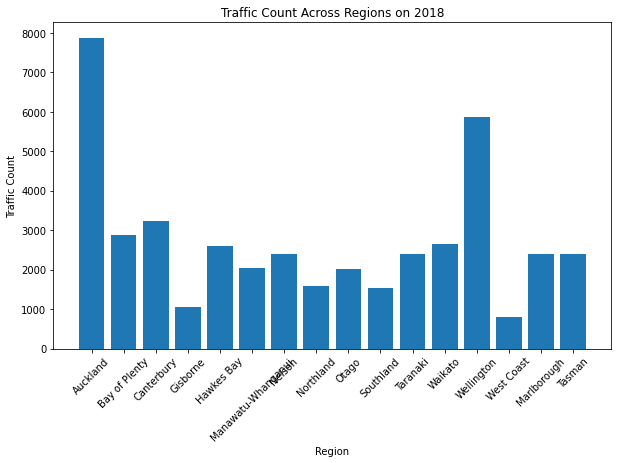

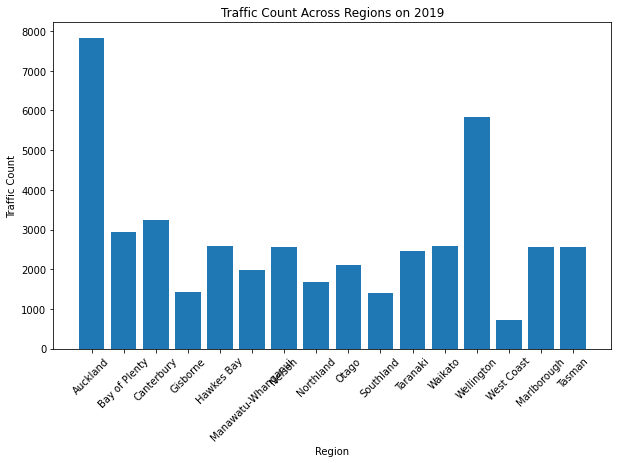

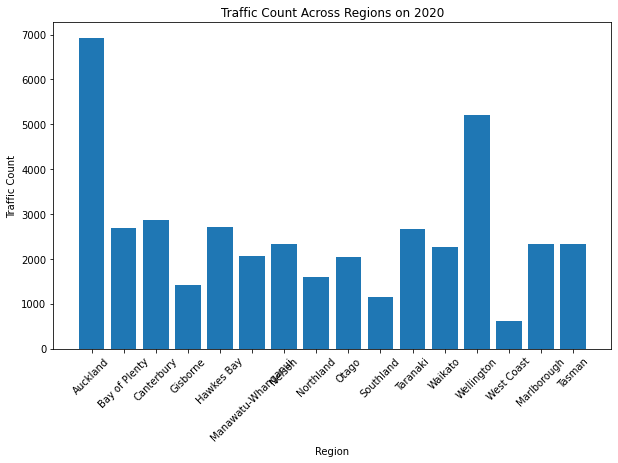

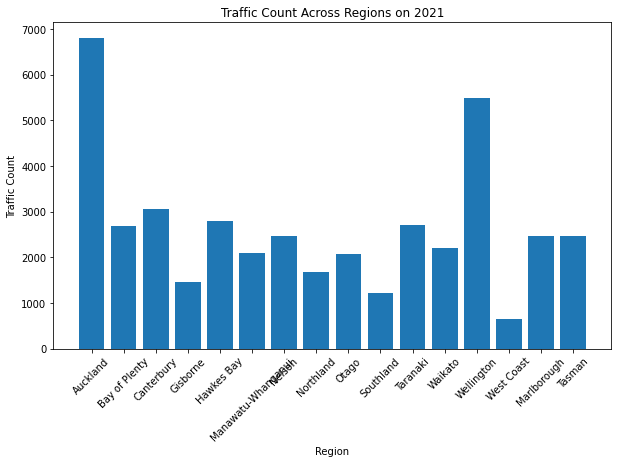

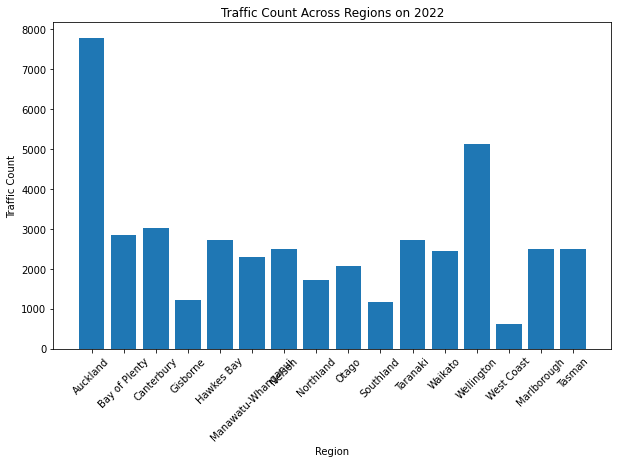

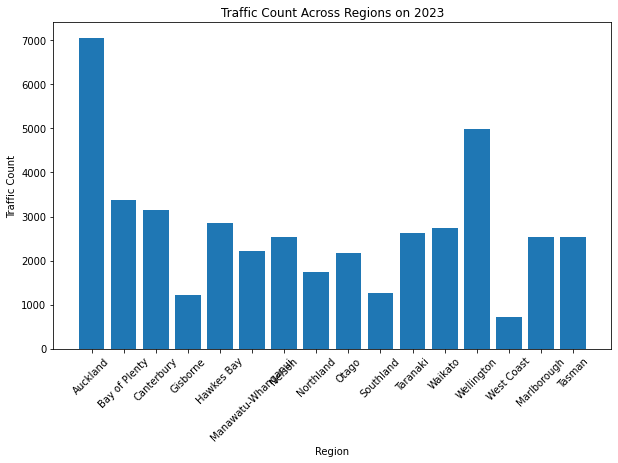

In [41]:
years = sorted([row.startDate for row in df_tra.select("startDate").distinct().collect()])

for year in years:
    
    filtered_df = df_tra.filter(col("startDate") == year)

    pd_df = filtered_df.select("regionName", "trafficCount").toPandas()
    pd_df["trafficCount"] = pd_df["trafficCount"].astype(float)

    plt.figure(figsize=(10, 6))
    plt.bar(pd_df["regionName"], pd_df["trafficCount"])
    plt.title(f"Traffic Count Across Regions on {year}")
    plt.xlabel("Region")
    plt.ylabel("Traffic Count")
    plt.xticks(rotation=45)
    plt.show()

Below are average daily traffic by year in the regions.

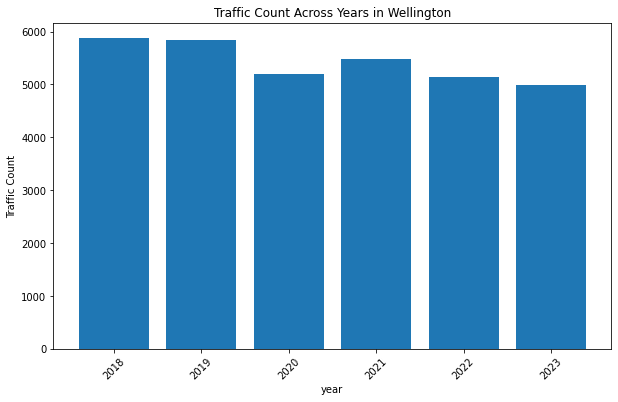

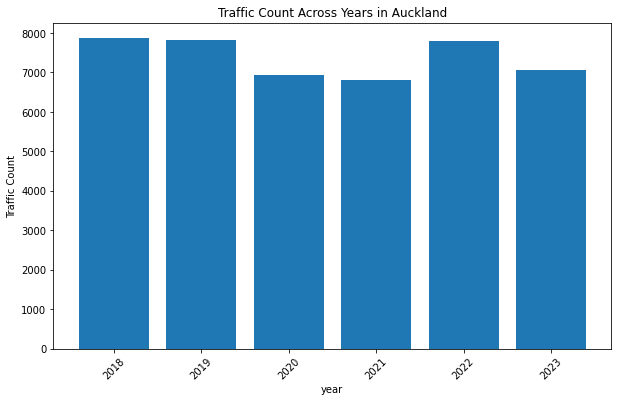

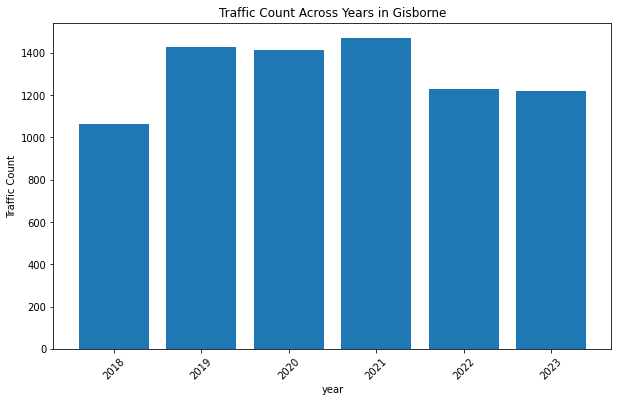

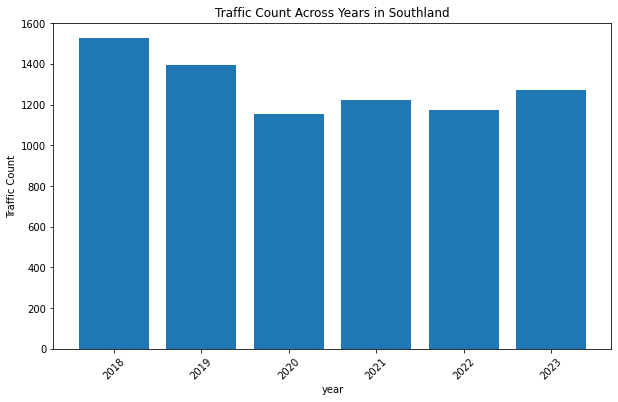

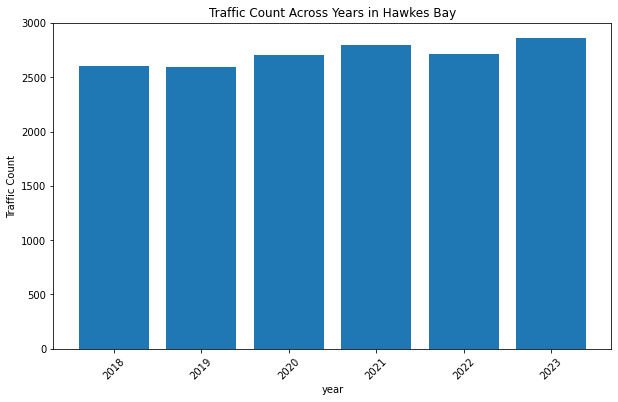

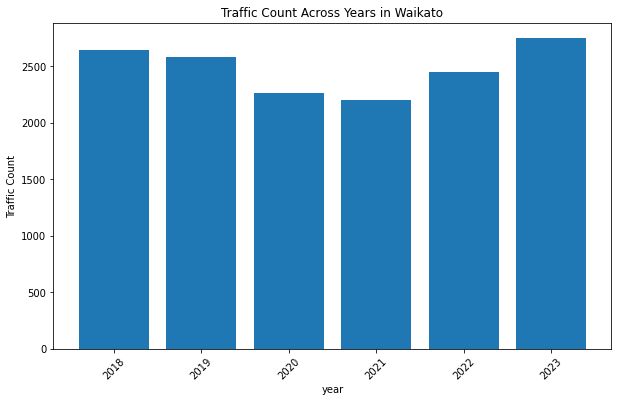

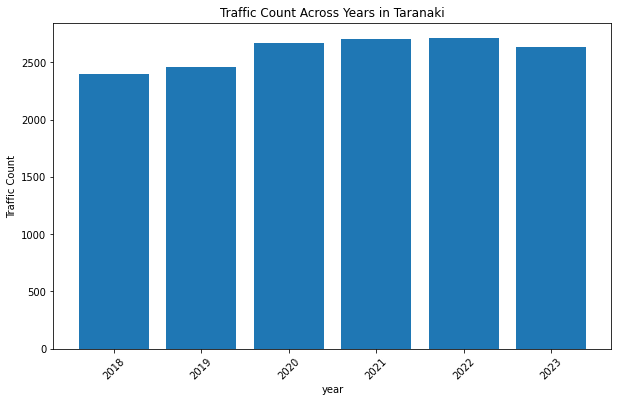

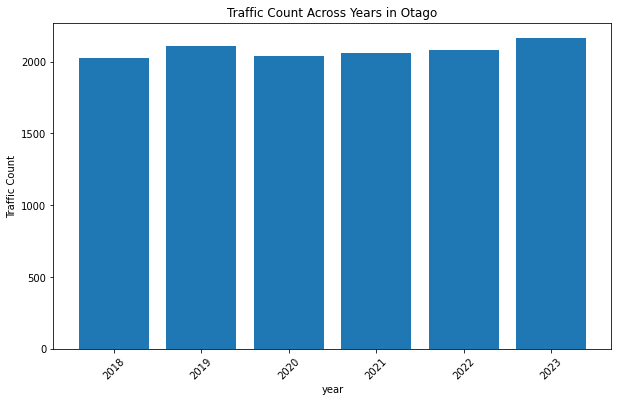

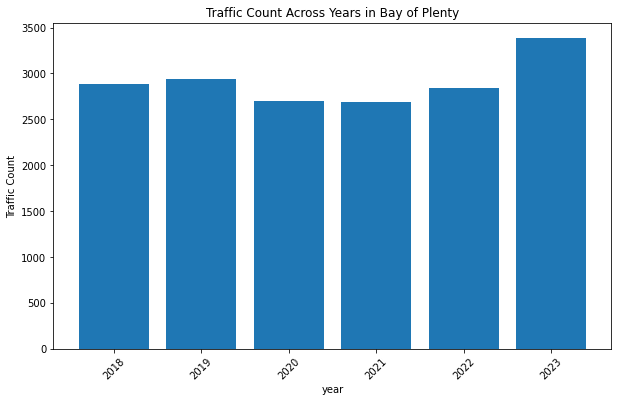

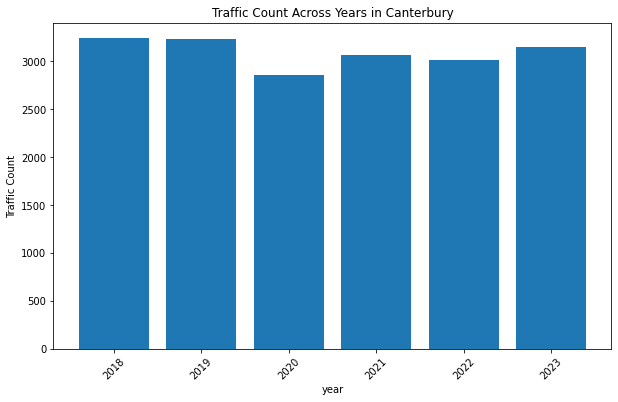

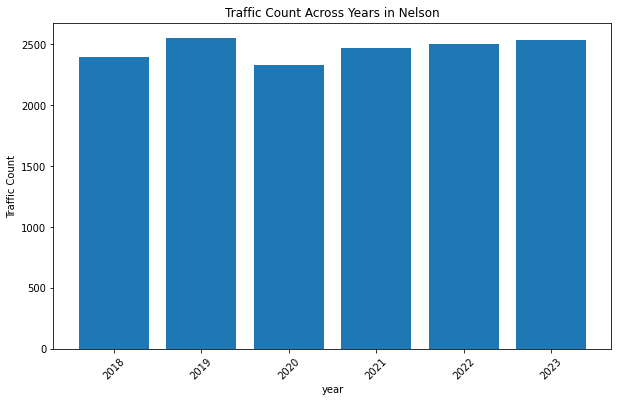

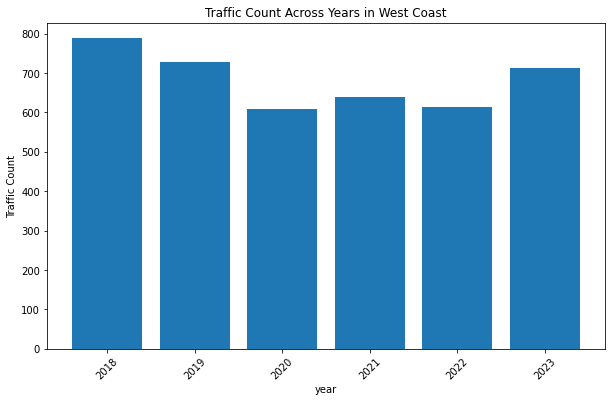

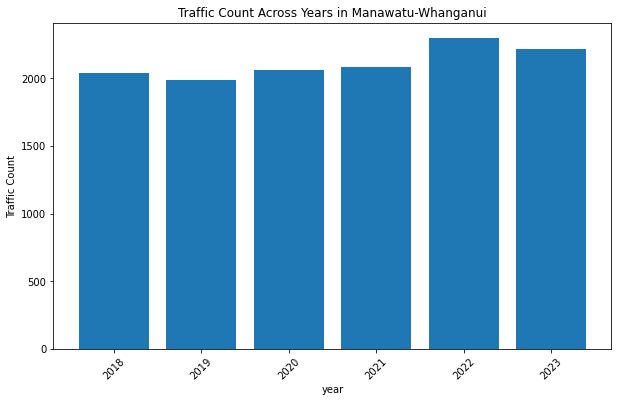

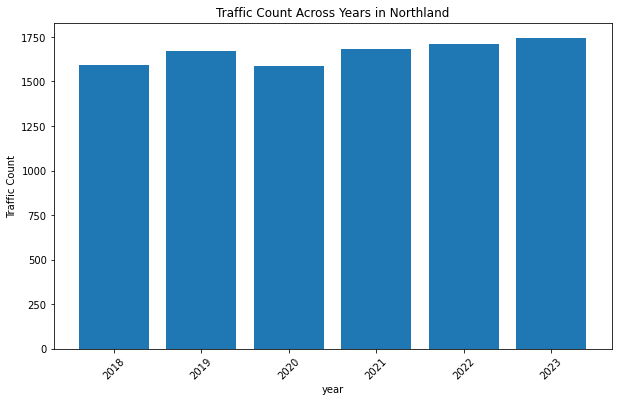

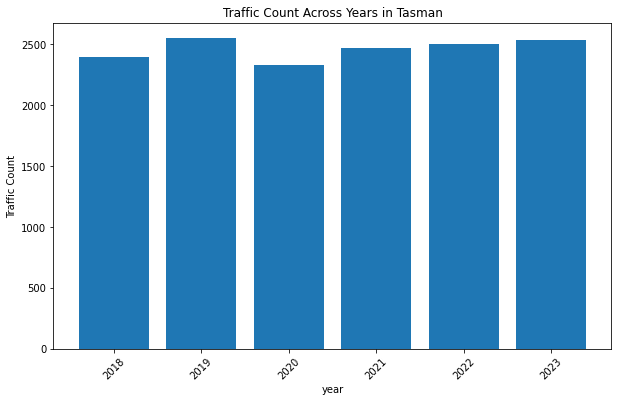

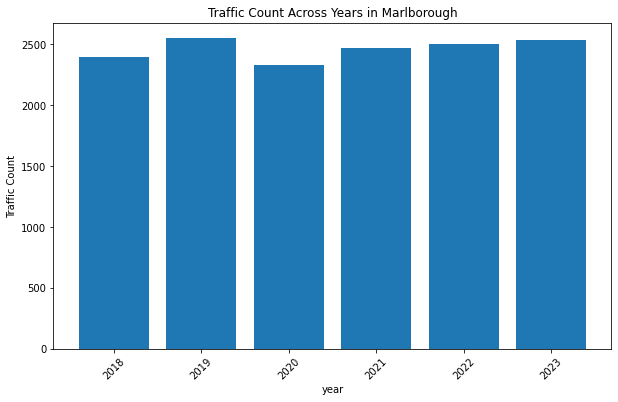

In [11]:
regions = [row.regionName for row in df_tra.select("regionName").distinct().collect()]

for region in regions:
    
    filtered_df = df_tra.filter(col("regionName") == region)

    pd_df = filtered_df.select("startDate", "trafficCount").toPandas()
    pd_df["trafficCount"] = pd_df["trafficCount"].astype(float)

    plt.figure(figsize=(10, 6))
    plt.bar(pd_df["startDate"], pd_df["trafficCount"])
    plt.title(f"Traffic Count Across Years in {region}")
    plt.xlabel("year")
    plt.ylabel("Traffic Count")
    plt.xticks(rotation=45)
    plt.show()

## 2.4 Verify data quality

In [9]:
df_EV.count()-df_EV.dropna().count()

0

In [10]:
df_cha.count()-df_cha.dropna().count()

80

df_cha has missing values and needs cleaning.

In [11]:
df_tra.count()-df_tra.dropna().count()

0

### Outlier: only after section 3 can you run the chunk below, because data needs cleaning and formatting.

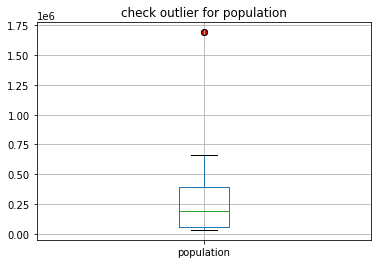

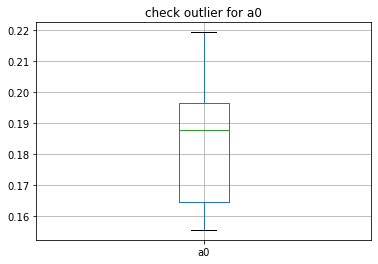

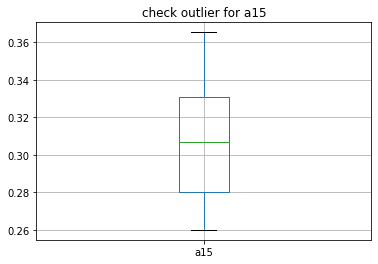

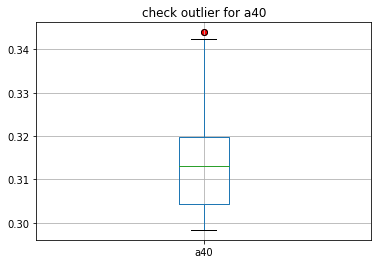

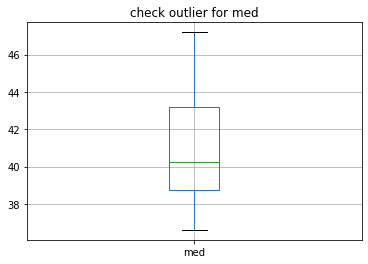

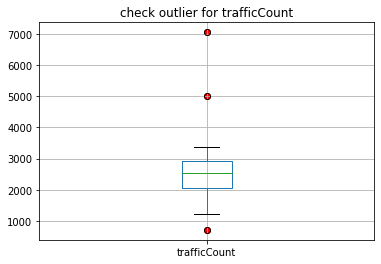

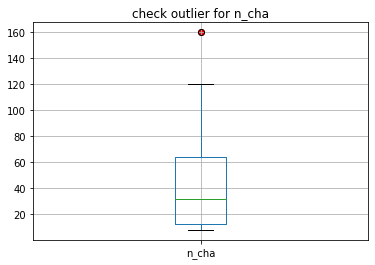

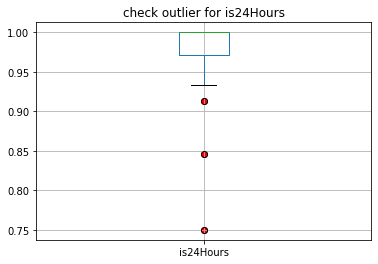

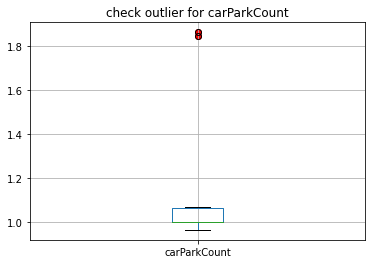

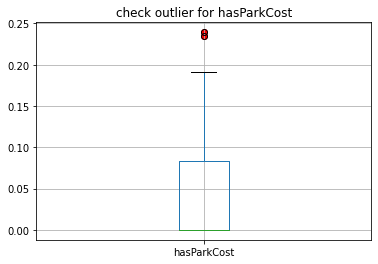

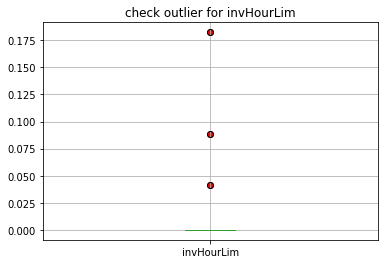

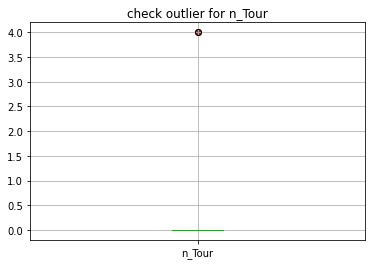

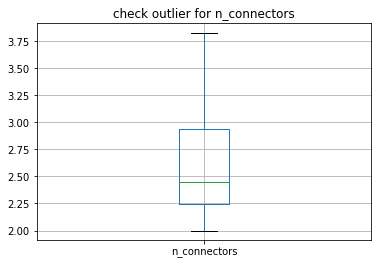

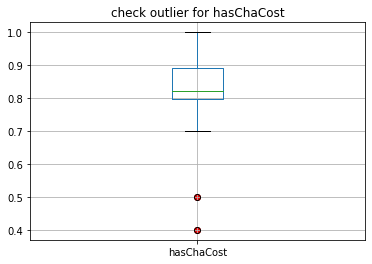

In [29]:
ol = []
cols = pop_tra_cha.columns[2:]
for col in cols:
    plt.figure()
    box = pop_tra_cha.boxplot(column=[col], return_type='dict')
    outliers = box['fliers'][0].get_ydata()
    ol.append(list(outliers))
    plt.scatter(x=[1] * len(outliers), y=outliers, c='red', marker='o', label='Outliers')
    plt.title(f'check outlier for {col}')
    plt.show()

In [30]:
pop_tra_cha

,Region,year,population,a0,a15,a40,med,trafficCount,n_cha,is24Hours,carParkCount,hasParkCost,invHourLim,n_Tour,n_connectors,hasChaCost
0,Northland,2023,204200.0,0.196376,0.274241,0.314887,42.8,1743.201415,47,1.000000,1.000000,0.191489,0.000000,0,2.425532,0.872340
1,Auckland,2023,1692400.0,0.191858,0.359489,0.309206,36.6,7053.445249,117,0.846154,1.846154,0.239316,0.182336,0,3.829060,0.401709
2,Waikato,2023,519900.0,0.200616,0.327178,0.298327,37.9,2748.196882,96,1.000000,1.864583,0.020833,0.000000,4,3.114583,0.791667
3,Bay of Plenty,2023,352500.0,0.195177,0.304113,0.302695,40.1,3384.699649,34,1.000000,1.058824,0.235294,0.000000,0,2.647059,0.941176
4,Gisborne,2023,52000.0,0.219231,0.309615,0.301923,37.7,1221.251464,13,1.000000,1.000000,0.000000,0.000000,0,2.307692,0.846154
5,Hawkes Bay,2023,183700.0,0.19706,0.297768,0.310833,40.4,2859.425435,18,1.000000,1.000000,0.000000,0.000000,0,2.333333,1.000000
6,Taranaki,2023,128000.0,0.199219,0.29375,0.316406,40.6,2632.212886,8,1.000000,1.000000,0.000000,0.000000,0,2.000000,1.000000
7,Manawatu-Whanganui,2023,259600.0,0.191063,0.315485,0.298921,39.4,2214.190473,45,1.000000,1.022222,0.000000,0.000000,0,2.711111,0.866667
8,Wellington,2023,545400.0,0.167217,0.365237,0.312431,37.6,4992.949186,120,0.983333,1.066667,0.033333,0.088889,0,3.083333,0.800000
9,Tasman,2023,59600.0,0.157718,0.260067,0.34396,47.1,2536.436994,10,1.000000,1.000000,0.000000,0.000000,0,2.200000,0.800000


In [43]:
for i in range(len(cols)):
    for outlier in ol[i]:
        col = cols[i]
        print(col, outlier)
        print(pop_tra_cha.loc[pop_tra_cha[col]==outlier, ['Region','year']], '\n')

population 1692400
     Region  year
1  Auckland  2023 

a40 0.34395973154362414
   Region  year
9  Tasman  2023 

trafficCount 711.9108579088472
        Region  year
12  West Coast  2023 

trafficCount 7053.445248754423
     Region  year
1  Auckland  2023 

trafficCount 4992.949186478589
       Region  year
8  Wellington  2023 

n_cha 160
        Region  year
13  Canterbury  2023 

is24Hours 0.8461538461538461
     Region  year
1  Auckland  2023 

is24Hours 0.75
    Region  year
10  Nelson  2023 

is24Hours 0.9125
        Region  year
13  Canterbury  2023 

carParkCount 1.8461538461538463
     Region  year
1  Auckland  2023 

carParkCount 1.8645833333333333
    Region  year
2  Waikato  2023 

hasParkCost 0.23931623931623933
     Region  year
1  Auckland  2023 

hasParkCost 0.23529411764705882
          Region  year
3  Bay of Plenty  2023 

invHourLim 0.18233618234188034
     Region  year
1  Auckland  2023 

invHourLim 0.08888888888333332
       Region  year
8  Wellington  2023 

invHo

# 3 Data preparation
## 3.1 Select the data

In [3]:
df_EV = pd.read_csv(file1)
df_EV = df_EV[df_EV["region"]=="New Zealand"]
df_EV = df_EV[df_EV["mode"]!="EV"]
df_EV = df_EV[["parameter", "year", "value"]].groupby(["parameter", "year"]).\
    sum().reset_index().pivot(index='year', columns='parameter', values='value')
df_EV

parameter,EV sales,EV sales share,EV stock,EV stock share
year,,,,
2010,10.0,0.0063,76.0,0.60061
2011,17.0,0.3299,93.0,0.62130
2012,28.0,0.1370,121.0,0.63260
2013,36.0,0.0190,157.0,0.62430
2014,320.0,0.1400,475.0,0.63900
2015,500.0,0.2000,975.0,0.66200
2016,1540.0,0.5700,2425.0,0.71000
2017,3441.0,1.2740,5966.0,0.84000
2018,5611.0,2.8100,11477.0,1.17000


In [4]:
df_cha = pd.read_csv(file2)
df_cha = df_cha.iloc[:, [12,13,7,8,9,10,11,14,16,18]].reset_index(drop=True)
df_cha.head(6)

,latitude,longitude,is24Hours,carParkCount,hasCarparkCost,maxTimeLimit,hasTouristAttraction,currentType,numberOfConnectors,hasChargingCost
0,-43.737450,170.100913,True,1,False,Unlimited,False,AC,1,True
1,-45.414702,167.710591,True,2,False,Unlimited,False,AC,1,True
2,-36.881664,174.783985,False,4,False,Unlimited,False,AC,4,False
3,-37.354558,175.080300,True,2,False,Unlimited,True,DC,3,True
4,-37.731714,175.222544,True,2,False,Unlimited,False,DC,3,True
5,-37.778559,175.298787,True,3,False,Unlimited,False,Mixed,5,False


In [5]:
df_pop = pd.read_excel(file6, sheet_name="Table 1")
df_age = pd.read_excel(file6, sheet_name="Table 4")

In [6]:
df_pop = df_pop.iloc[4:52, [0] + list(range(2,9))].reset_index(drop=True)
df_pop.columns = ["Region", "2018", "2023", "2028", "2033", "2038", "2043", "2048"]
df_pop.head(6)

,Region,2018,2023,2028,2033,2038,2043,2048
0,Northland region,NaN,208700.0,223500.0,237100.0,249700.0,261700.0,273200.0
1,NaN,185800,204200.0,214100.0,222600.0,229800.0,236000.0,241300.0
2,NaN,NaN,199600.0,204700.0,208200.0,210000.0,210600.0,210000.0
3,Auckland region,NaN,1736300.0,1856600.0,2001100.0,2144900.0,2288200.0,2430000.0
4,NaN,1654800,1692400.0,1765500.0,1859400.0,1948700.0,2034100.0,2114000.0
5,NaN,NaN,1648500.0,1674800.0,1718700.0,1755300.0,1784800.0,1805700.0


In [7]:
df_age = df_age.iloc[5:181, list(range(0,6))+[-1]].reset_index(drop=True)
df_age.columns = ["Region", "year", "0–14", "15–39", "40–64", "65+", "med"]
df_age.head(6)

,Region,year,0–14,15–39,40–64,65+,med
0,Northland region,1996,37200,46600,39900,16900,33.7
1,NaN,2001,36300,43200,45800,19100,36.6
2,NaN,2006,35300,43500,51800,22100,38.8
3,NaN,2013,36400,42900,56500,28900,41.5
4,NaN,2018,38600,50100,61200,36000,42.3
5,NaN,2023,40100,56000,64300,43800,42.8


## 3.2 Clean the data

In [8]:
df_cha['maxTimeLimit'] = df_cha['maxTimeLimit'].replace(['Unlimited', 'No Limit'], 0)
df_cha[df_cha['maxTimeLimit'] == 'None'] = 0
df_cha['maxTimeLimit'].value_counts()

0      704
120     66
180     10
240      4
90       2
Name: maxTimeLimit, dtype: int64

In [9]:
for i in range(0, len(df_pop), 3):
    region = df_pop.loc[i, 'Region']
    df_pop.loc[i+1 : i+2, 'Region'] = region
    
# only consider 50 percentile prediction
df_pop = df_pop[df_pop.index%3 == 1].reset_index(drop=True)

In [10]:
for i in range(0, len(df_age), 11):
    region = df_age.loc[i, 'Region']
    df_age.loc[i+1 : i+10, 'Region'] = region

## 3.3 Construct the data

df_cha maxTimeLimit convert to 1/maxTimeLimit in hours as invHourLim:

In [11]:
def update_value(val):
    val = float(val)
    try:
        return 60/val
    except ZeroDivisionError:
        return val
df_cha['maxTimeLimit'] = df_cha['maxTimeLimit'].apply(update_value)
df_cha = df_cha.rename(columns = {"maxTimeLimit": "invHourLim"})

Uncomment and run coord2region() if you choose to use API to get region info:

In [12]:
def coord2region():
    key = "your key" # change it
    map_clinet = googlemaps.Client(key)
    coords = df_cha[["latitude", "longitude"]].values.tolist()
    regions = []
    for coord in coords:
        response = map_clinet.reverse_geocode(coord)
        regions.append(response[0]["address_components"][-3]['long_name'])
    df_cha2 = pd.concat([pd.DataFrame({"Region":regions}),\
                        df_cha.iloc[:,2:]], axis = 1)
    df_cha2.to_csv("2 clean_cha_data.csv", index=False)
    return df_cha2

# df_cha = coord2region()

You can also choose to load the processed data:

In [13]:
df_cha = pd.read_csv(file4)

## 3.4 Integrate various data sources

In [14]:
df_cha["Region"] = df_cha["Region"].str.replace("Wanganui", "Whanganui").str.replace("'", "")

### population: comprehensive population profile

In [15]:
df_pop["Region"] = df_pop["Region"].str[:-7]
df_pop["Region"] = df_pop["Region"].str.replace('ū', 'u')
df_pop["Region"] = df_pop["Region"].str.replace("'", "")
df_pop = pd.melt(df_pop, id_vars=['Region'], var_name='year', value_name='population')

In [16]:
df_age["Region"] = df_age["Region"].str[:-7]
df_age["Region"] = df_age["Region"].str.replace('ū', 'u')
df_age["Region"] = df_age["Region"].str.replace("'", "")

In [17]:
df_pop['year'] = df_pop['year'].astype(int)
df_age['year'] = df_age['year'].astype(int)
population = pd.merge(df_pop, df_age, on=['Region', 'year'], how='inner')

In [18]:
# represent age group as portion
population['a0'] = population['0–14']/population['population']
population['a15'] = population['15–39']/population['population']
population['a40'] = population['40–64']/population['population']
population = population[['Region', 'year', 'population', 'a0', 'a15', 'a40', 'med']]
population

,Region,year,population,a0,a15,a40,med
0,Northland,2018,185800,0.20775,0.269645,0.329386,42.3
1,Auckland,2018,1654800,0.195854,0.380892,0.304206,34.6
2,Waikato,2018,475600,0.207948,0.325694,0.308873,37.1
3,Bay of Plenty,2018,320800,0.204489,0.29707,0.316085,39.9
4,Gisborne,2018,49500,0.234343,0.30303,0.311111,36.6
...,...,...,...,...,...,...,...
107,Marlborough,2048,55200.0,0.132246,0.217391,0.335145,52.6
108,West Coast,2048,30000.0,0.133333,0.223333,0.336667,51.5
109,Canterbury,2048,782700.0,0.144883,0.298454,0.331417,44.2
110,Otago,2048,281100.0,0.131626,0.323017,0.299538,44


### pop_tra_cha: design matrix1, regress on year 2023 data

In [19]:
df_tra = pd.read_csv(file5)
df_tra.columns = ['year', 'Region', 'trafficCount']
pop_tra_cha = pd.merge(population[population["year"]==2023], df_tra[df_tra["year"]==2023], on=["Region", "year"])

In [20]:
cha_summarize = df_cha.groupby('Region').agg(\
    n_cha = pd.NamedAgg(column='Region', aggfunc='size'),\
    is24Hours = ('is24Hours', 'mean'),\
    carParkCount = ('carParkCount', 'mean'),\
    hasParkCost = ('hasCarparkCost', 'mean'),\
    invHourLim = ('invHourLim', 'mean'),\
    n_Tour = ('hasTouristAttraction', 'sum'),\
    n_connectors = ('numberOfConnectors', 'mean'),\
    hasChaCost = ('hasChargingCost', 'mean'))
pop_tra_cha = pd.merge(pop_tra_cha, cha_summarize, on="Region")
pop_tra_cha

,Region,year,population,a0,a15,a40,med,trafficCount,n_cha,is24Hours,carParkCount,hasParkCost,invHourLim,n_Tour,n_connectors,hasChaCost
0,Northland,2023,204200.0,0.196376,0.274241,0.314887,42.8,1743.201415,47,1.000000,1.000000,0.191489,0.000000,0,2.425532,0.872340
1,Auckland,2023,1692400.0,0.191858,0.359489,0.309206,36.6,7053.445249,117,0.846154,1.846154,0.239316,0.182336,0,3.829060,0.401709
2,Waikato,2023,519900.0,0.200616,0.327178,0.298327,37.9,2748.196882,96,1.000000,1.864583,0.020833,0.000000,4,3.114583,0.791667
3,Bay of Plenty,2023,352500.0,0.195177,0.304113,0.302695,40.1,3384.699649,34,1.000000,1.058824,0.235294,0.000000,0,2.647059,0.941176
4,Gisborne,2023,52000.0,0.219231,0.309615,0.301923,37.7,1221.251464,13,1.000000,1.000000,0.000000,0.000000,0,2.307692,0.846154
5,Hawkes Bay,2023,183700.0,0.19706,0.297768,0.310833,40.4,2859.425435,18,1.000000,1.000000,0.000000,0.000000,0,2.333333,1.000000
6,Taranaki,2023,128000.0,0.199219,0.29375,0.316406,40.6,2632.212886,8,1.000000,1.000000,0.000000,0.000000,0,2.000000,1.000000
7,Manawatu-Whanganui,2023,259600.0,0.191063,0.315485,0.298921,39.4,2214.190473,45,1.000000,1.022222,0.000000,0.000000,0,2.711111,0.866667
8,Wellington,2023,545400.0,0.167217,0.365237,0.312431,37.6,4992.949186,120,0.983333,1.066667,0.033333,0.088889,0,3.083333,0.800000
9,Tasman,2023,59600.0,0.157718,0.260067,0.34396,47.1,2536.436994,10,1.000000,1.000000,0.000000,0.000000,0,2.200000,0.800000


### pop_tra: design matrix2, time series 2018-2023
popu: using Gaussian process to fill the gap years data like 2019 to 2022.

In [21]:
years_to_predict = np.array([year for year in range(2019, 2048) if year not in [2023, 2028, 2033, 2038, 2043]])
pd_years = pd.DataFrame(years_to_predict)
nYears = len(pd_years)
regions = list(population['Region'].unique())

popu = None
for region in regions:
    
    pop = population[population['Region'] == region]
    
    kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(pop[['year']], pop[['population','a0','a15','a40','med']])
    predicted_counts = gp.predict(years_to_predict.reshape(-1, 1))
    
    if popu is None:
        popu = pd.concat([pd.DataFrame([region]*nYears), pd_years, pd.DataFrame(predicted_counts)], axis=1)
    else:
        new = pd.concat([pd.DataFrame([region]*nYears), pd_years, pd.DataFrame(predicted_counts)], axis=1)
        popu = pd.concat([popu, new])
        
popu.columns = population.columns
popu = pd.concat([popu, population]).sort_values(by=['Region','year']).reset_index(drop=True)

/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GaussianProcessRegressor was fitted with feature names

In [22]:
pop_tra = pd.merge(df_tra, popu, on=['Region', 'year'])
pop_tra

,year,Region,trafficCount,population,a0,a15,a40,med
0,2018,Auckland,7869.100052,1654800,0.195854,0.380892,0.304206,34.6
1,2018,Bay of Plenty,2888.027393,320800,0.204489,0.29707,0.316085,39.9
2,2018,Canterbury,3240.199329,622800,0.179191,0.340077,0.323057,38.4
3,2018,Gisborne,1061.320590,49500,0.234343,0.30303,0.311111,36.6
4,2018,Hawkes Bay,2603.759573,172400,0.207077,0.290603,0.322506,40.2
...,...,...,...,...,...,...,...,...
91,2019,Tasman,2551.922917,55542.55273,0.173258,0.250806,0.364145,46.110639
92,2020,Tasman,2328.157837,56847.810503,0.168841,0.254536,0.359155,46.279833
93,2021,Tasman,2468.126041,57938.961279,0.164696,0.257373,0.353924,46.50647
94,2022,Tasman,2502.050395,58845.344947,0.160957,0.259231,0.348774,46.783598


### EV_pop_tra: design matrix3, time series 2018-2022

In [23]:
pop_tra_summarize = pop_tra.groupby('year').agg(\
    trafficCount = ('trafficCount', 'sum'),\
    population = ('population', 'sum'),\
    a0 = ('a0', 'sum'),\
    a15 = ('a15', 'sum'),\
    a40 = ('a40', 'sum'),\
    med = ('med', 'mean'))
EV_pop_tra = pd.merge(pop_tra_summarize, df_EV, on="year")
EV_pop_tra

,trafficCount,population,a0,a15,a40,med,EV sales,EV sales share,EV stock,EV stock share
year,,,,,,,,,,
2018,43739.194349,4899600,3.082205,4.916751,5.231953,40.100000,5611.0,2.81,11477.0,1.170
2019,44453.221292,4959690.370262,3.063813,4.904467,5.232624,40.233144,7017.0,6.02,18342.0,1.567
2020,41150.667503,5013220.826305,3.035582,4.905969,5.204251,40.389553,5520.0,9.72,23957.0,1.855
2021,42293.845408,5061640.536432,3.000226,4.915106,5.157703,40.570364,10579.0,24.47,36638.0,2.685
2022,43260.478449,5106343.533617,2.960289,4.926202,5.102759,40.774657,28817.0,20.35,66896.0,2.900


## 3.5 Format the data

In [24]:
df_cha.info()
df_cha['currentType'] = df_cha['currentType'].astype('category')
df_cha["Region"] = df_cha["Region"].astype('category')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786 entries, 0 to 785
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Region                786 non-null    object 
 1   is24Hours             786 non-null    bool   
 2   carParkCount          786 non-null    int64  
 3   hasCarparkCost        786 non-null    bool   
 4   invHourLim            786 non-null    float64
 5   hasTouristAttraction  786 non-null    bool   
 6   currentType           786 non-null    object 
 7   numberOfConnectors    786 non-null    int64  
 8   hasChargingCost       786 non-null    bool   
dtypes: bool(4), float64(1), int64(2), object(2)
memory usage: 33.9+ KB


In [25]:
popu.info()
popu['Region'] = population['Region'].astype('category')
popu[popu.columns[2]] = popu.iloc[:,2].astype(int)
popu[popu.columns[3:]] = popu.iloc[:,3:].astype(float)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Region      496 non-null    object
 1   year        496 non-null    int64 
 2   population  496 non-null    object
 3   a0          496 non-null    object
 4   a15         496 non-null    object
 5   a40         496 non-null    object
 6   med         496 non-null    object
dtypes: int64(1), object(6)
memory usage: 27.2+ KB


In [26]:
pop_tra_cha.info()
pop_tra_cha['Region'] = pop_tra_cha['Region'].astype('category')
pop_tra_cha[pop_tra_cha.columns[2]] = pop_tra_cha.iloc[:,2].astype(int)
pop_tra_cha[pop_tra_cha.columns[3:7]] = pop_tra_cha.iloc[:,3:7].astype(float)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16 entries, 0 to 15
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Region        16 non-null     object 
 1   year          16 non-null     int64  
 2   population    16 non-null     object 
 3   a0            16 non-null     object 
 4   a15           16 non-null     object 
 5   a40           16 non-null     object 
 6   med           16 non-null     object 
 7   trafficCount  16 non-null     float64
 8   n_cha         16 non-null     int64  
 9   is24Hours     16 non-null     float64
 10  carParkCount  16 non-null     float64
 11  hasParkCost   16 non-null     float64
 12  invHourLim    16 non-null     float64
 13  n_Tour        16 non-null     int64  
 14  n_connectors  16 non-null     float64
 15  hasChaCost    16 non-null     float64
dtypes: float64(7), int64(3), object(6)
memory usage: 2.1+ KB


In [27]:
pop_tra.info()
pop_tra['Region'] = pop_tra['Region'].astype('category')
pop_tra[pop_tra.columns[3]] = pop_tra.iloc[:,3].astype(int)
pop_tra[pop_tra.columns[4:]] = pop_tra.iloc[:,4:].astype(float)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96 entries, 0 to 95
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          96 non-null     int64  
 1   Region        96 non-null     object 
 2   trafficCount  96 non-null     float64
 3   population    96 non-null     object 
 4   a0            96 non-null     object 
 5   a15           96 non-null     object 
 6   a40           96 non-null     object 
 7   med           96 non-null     object 
dtypes: float64(1), int64(1), object(6)
memory usage: 6.8+ KB


In [28]:
EV_pop_tra.info()
EV_pop_tra[EV_pop_tra.columns[1]] = EV_pop_tra.iloc[:,1].astype(int)
EV_pop_tra[EV_pop_tra.columns[2:6]] = EV_pop_tra.iloc[:,2:6].astype(float)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 2018 to 2022
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   trafficCount    5 non-null      float64
 1   population      5 non-null      object 
 2   a0              5 non-null      object 
 3   a15             5 non-null      object 
 4   a40             5 non-null      object 
 5   med             5 non-null      float64
 6   EV sales        5 non-null      float64
 7   EV sales share  5 non-null      float64
 8   EV stock        5 non-null      float64
 9   EV stock share  5 non-null      float64
dtypes: float64(6), object(4)
memory usage: 440.0+ bytes


# 4 Data transformation
## 4.1 Reduce the data
### pop_tra_cha: charging station allocation in regions

In [29]:
Y = pop_tra_cha["n_cha"]
for x in [col for col in range(2,16) if col != 8]:
    X = sm.add_constant(pop_tra_cha[pop_tra_cha.columns[x]])
    model = sm.OLS(Y, X).fit()
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  n_cha   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     17.64
Date:                Fri, 20 Oct 2023   Prob (F-statistic):           0.000891
Time:                        18:27:14   Log-Likelihood:                -77.607
No. Observations:                  16   AIC:                             159.2
Df Residuals:                      14   BIC:                             160.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.3153     10.590      2.013      0.0

/home/ubuntu/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/ubuntu/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/ubuntu/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/ubuntu/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/home/ubuntu/.local/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1477: UserWarning: kurtosistest on

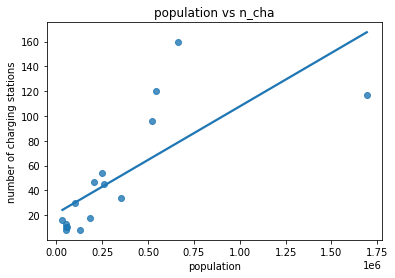

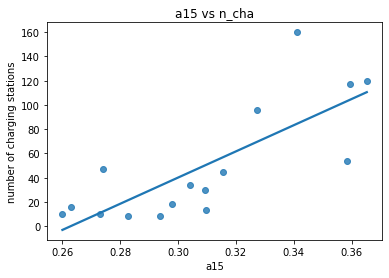

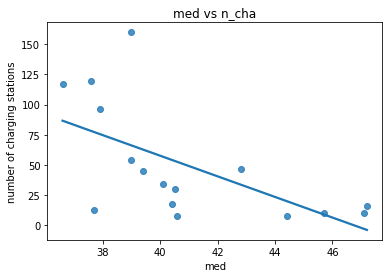

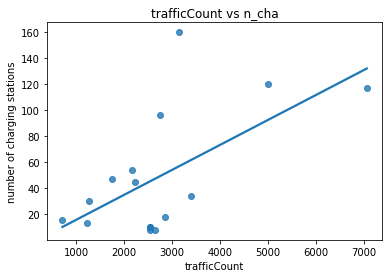

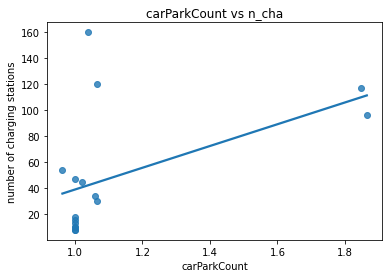

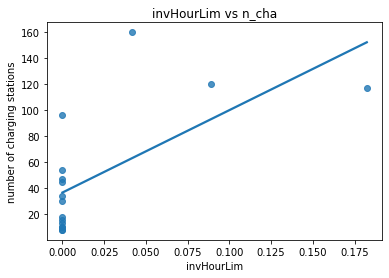

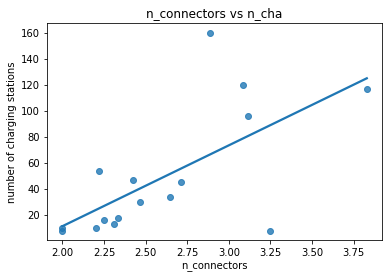

In [82]:
cols = ['population','a15','med','trafficCount','carParkCount','invHourLim','n_connectors']
X = pop_tra_cha[cols]
for column in X.columns:
    plt.figure()
    sns.regplot(x=X[column], y=Y, ci=None)
    plt.title(f'{column} vs n_cha')
    plt.xlabel(f'{column}')
    plt.ylabel('number of charging stations')

## 4.2 Project the data
n_cha relations with 7 variables looks linear and doesn't need log or exp transformation. 

# 5 Data-mining methods selection
regression

# 6 Data-mining algorithms selection
OLS and SVM

# 7 Data Mining
## 7.1 Create and justify test designs 7.2 Conduct data mining

In [32]:
X["isAuckland"] = pop_tra_cha['Region'].apply(lambda x: x == 'Auckland').astype(int)
cols = ['population','a15','med','trafficCount','carParkCount','invHourLim','n_connectors','isAuckland']
target_column = 'n_cha'

/tmp/ipykernel_12566/3259188185.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["isAuckland"] = pop_tra_cha['Region'].apply(lambda x: x == 'Auckland').astype(int)


In [47]:
assembler = VectorAssembler(inputCols=cols, outputCol="features")
M = spark.createDataFrame(pd.concat([Y,X], axis=1))
M = assembler.transform(M).select("n_cha", "features")
M.show()

+-----+--------------------+
|n_cha|            features|
+-----+--------------------+
|   47|[204200.0,0.27424...|
|  117|[1692400.0,0.3594...|
|   96|[519900.0,0.32717...|
|   34|[352500.0,0.30411...|
|   13|[52000.0,0.309615...|
|   18|[183700.0,0.29776...|
|    8|[128000.0,0.29375...|
|   45|[259600.0,0.31548...|
|  120|[545400.0,0.36523...|
|   10|[59600.0,0.260067...|
|    8|[54500.0,0.282568...|
|   10|[52000.0,0.273076...|
|   16|[32700.0,0.262996...|
|  160|[661000.0,0.34114...|
|   54|[248600.0,0.35840...|
|   30|[102500.0,0.30926...|
+-----+--------------------+



In [49]:
errs = [[],[],[]]
epoc = 10

for i in range(epoc):
    
    train, test = M.randomSplit([0.75,0.25])
    
    lr = LinearRegression(featuresCol="features", labelCol=target_column)
    model = lr.fit(train)
    errs[0].append(model.evaluate(test).rootMeanSquaredError)
    
    gbt = GBTRegressor(featuresCol="features", labelCol=target_column)
    model = gbt.fit(train)
    evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
    errs[1].append(evaluator.evaluate(model.transform(test)))
    
    rf = RandomForestRegressor(featuresCol="features", labelCol=target_column)
    model = rf.fit(train)
    evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
    errs[2].append(evaluator.evaluate(model.transform(test)))   

for i in errs:
    print(sum(i)/epoc)

23/10/20 13:16:06 WARN Instrumentation: [8b2f7a11] regParam is zero, which might cause numerical instability and overfitting.
23/10/20 13:16:07 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 13 (= number of training instances)
23/10/20 13:16:09 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 13 (= number of training instances)
23/10/20 13:16:10 WARN Instrumentation: [c8a558ea] regParam is zero, which might cause numerical instability and overfitting.
23/10/20 13:16:10 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 14 (= number of training instances)
23/10/20 13:16:13 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 14 (= number of training instances)
23/10/20 13:16:14 WARN Instrumentation: [1790bd61] regParam is zero, which might cause numerical instability and overfitting.
23/10/20 13:16:14 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 14 (= number of training instances)
23/10/20 13:

45.50065036141676
21.324902063768512
22.257760777621492


Gradient-boosted trees has lowest root mean squared error. Use GBT with full data.

In [43]:
gbt = GBTRegressor(featuresCol="features", labelCol=target_column)
model = gbt.fit(M)
model.featureImportances

23/10/20 13:37:51 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 16 (= number of training instances)


SparseVector(8, {0: 0.9354, 1: 0.0018, 2: 0.053, 3: 0.0012, 4: 0.0083, 6: 0.0003})

Feature 5 and 7 are not in the model.\
Dredge a lesser model, without the variable of lowest importance, 6: n_connectors. Compare with full model by RMSE.

In [51]:
cols = ['population','a15','med','trafficCount','carParkCount']
M = spark.createDataFrame(pd.concat([Y,X[cols]], axis=1))
assembler = VectorAssembler(inputCols=cols, outputCol="features")
M = assembler.transform(M).select("n_cha", "features")

err = []

for i in range(epoc):
    
    train, test = M.randomSplit([0.75,0.25])
    gbt = GBTRegressor(featuresCol="features", labelCol=target_column)
    model = gbt.fit(train)
    evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
    evaluator.evaluate(model.transform(test))
    err.append(evaluator.evaluate(model.transform(test)))
    
sum(err)/epoc

23/10/20 13:49:15 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 13 (= number of training instances)
23/10/20 13:49:19 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 14 (= number of training instances)
23/10/20 13:49:26 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 14 (= number of training instances)
23/10/20 13:49:32 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 13 (= number of training instances)
23/10/20 13:49:35 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 11 (= number of training instances)
23/10/20 13:49:38 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 13 (= number of training instances)
23/10/20 13:49:44 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 13 (= number of training instances)
23/10/20 13:49:48 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 13 (= number of training instances)
23/10/20 13:49:53 WARN D

20.301903747915663

In [34]:
gbt = GBTRegressor(featuresCol="features", labelCol=target_column)
model = gbt.fit(M)
model.featureImportances

23/10/20 14:54:39 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 16 (= number of training instances)


SparseVector(5, {0: 0.9357, 1: 0.0018, 2: 0.053, 3: 0.0012, 4: 0.0083})

The test error is lower.\
Dredge a lesser model, without the variable of lowest importance, 3: trafficCount. Compare with full model by RMSE.

In [56]:
cols = ['population','a15','med','carParkCount']
M = spark.createDataFrame(pd.concat([Y,X[cols]], axis=1))
assembler = VectorAssembler(inputCols=cols, outputCol="features")
M = assembler.transform(M).select("n_cha", "features")

err = []

for i in range(epoc):
    
    train, test = M.randomSplit([0.75,0.25])
    gbt = GBTRegressor(featuresCol="features", labelCol=target_column)
    model = gbt.fit(train)
    evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
    evaluator.evaluate(model.transform(test))
    err.append(evaluator.evaluate(model.transform(test)))
    
sum(err)/epoc

23/10/20 13:54:18 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 10 (= number of training instances)
23/10/20 13:54:22 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 12 (= number of training instances)
23/10/20 13:54:26 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 12 (= number of training instances)
23/10/20 13:54:27 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 11 (= number of training instances)
23/10/20 13:54:29 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 13 (= number of training instances)
23/10/20 13:54:31 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 9 (= number of training instances)
23/10/20 13:54:33 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 11 (= number of training instances)
23/10/20 13:54:37 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 14 (= number of training instances)
23/10/20 13:54:41 WARN De

27.453061400792297

The test error is higher. From now on, reducing number of predictors should not reduce test error. The final model is:\
    GBT (n_cha ~ ['population','a15','med','carParkCount'])

In [33]:
gbt = GBTRegressor(featuresCol="features", labelCol=target_column)
model = gbt.fit(M)

23/10/20 14:03:36 WARN DecisionTreeMetadata: DecisionTree reducing maxBins from 32 to 16 (= number of training instances)


## 7.3 Search for patterns

In [35]:
model.featureImportances

SparseVector(5, {0: 0.9357, 1: 0.0018, 2: 0.053, 3: 0.0012, 4: 0.0083})

In [39]:
fitted = model.transform(M)
fitted.select('features', 'n_cha', 'prediction').show()

+--------------------+-----+------------------+
|            features|n_cha|        prediction|
+--------------------+-----+------------------+
|[204200.0,0.27424...|   47|              47.0|
|[1692400.0,0.3594...|  117|             117.0|
|[519900.0,0.32717...|   96|              96.0|
|[352500.0,0.30411...|   34|              34.0|
|[52000.0,0.309615...|   13|12.953883139815726|
|[183700.0,0.29776...|   18|              18.0|
|[128000.0,0.29375...|    8| 8.025940733853652|
|[259600.0,0.31548...|   45|              45.0|
|[545400.0,0.36523...|  120|             120.0|
|[59600.0,0.260067...|   10| 9.997117696238483|
|[54500.0,0.282568...|    8| 8.025940733853652|
|[52000.0,0.273076...|   10| 9.997117696238483|
|[32700.0,0.262996...|   16|              16.0|
|[661000.0,0.34114...|  160|             160.0|
|[248600.0,0.35840...|   54|              54.0|
|[102500.0,0.30926...|   30|              30.0|
+--------------------+-----+------------------+



# 8 Interpretation
## 8.2 Visualize the data, results, models, and patterns

In [57]:
merged_df = pd.concat([Y, fitted.select('prediction').toPandas()], axis=1).set_index(pd.Index(pop_tra_cha['Region']))
merged_df.columns = ['Observed n_cha', 'Fitted n_cha']
merged_df

,Observed n_cha,Fitted n_cha
Region,,
Northland,47,47.000000
Auckland,117,117.000000
Waikato,96,96.000000
Bay of Plenty,34,34.000000
Gisborne,13,12.953883
Hawkes Bay,18,18.000000
Taranaki,8,8.025941
Manawatu-Whanganui,45,45.000000
Wellington,120,120.000000


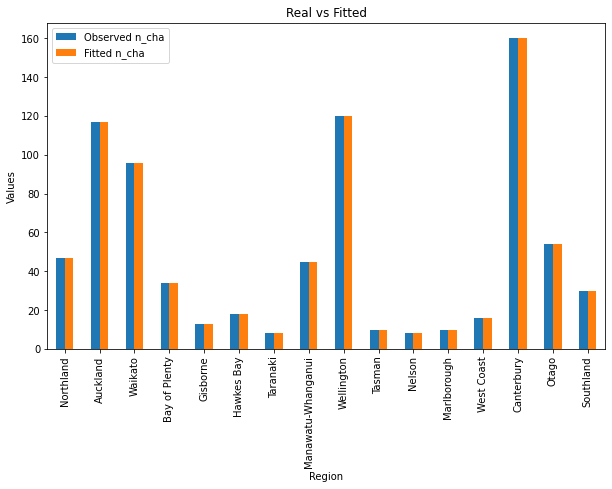

In [58]:
merged_df.plot(kind='bar', figsize=(10, 6))
plt.title('Real vs Fitted')
plt.xlabel('Region')
plt.ylabel('Values')
plt.show()

## 8.5 Iterate prior steps 1–7
### df_cha: charging station attributes
Logistic regression to find out statstically significant variables.

In [31]:
dum = ['is24Hours','hasCarparkCost','hasTouristAttraction','currentType','hasChargingCost','Region']
X = pd.get_dummies(df_cha, columns=dum, drop_first=True)
Y = X[X.columns[9:]]
X = X[X.columns[:9]]

In [30]:
for x in X.columns:
    x = sm.add_constant(X[x])
    model = sm.MNLogit(Y, x).fit()
    print(model.summary())

Optimization terminated successfully.
         Current function value: 1.927603
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  786
Model:                        MNLogit   Df Residuals:                      758
Method:                           MLE   Df Model:                           14
Date:                Fri, 20 Oct 2023   Pseudo R-squ.:                  0.1484
Time:                        10:30:10   Log-Likelihood:                -1515.1
converged:                       True   LL-Null:                       -1779.2
Covariance Type:            nonrobust   LLR p-value:                1.001e-103
        y=Region_Canterbury       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           2.4822      0.441      5.624      0.000   

/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3025: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3026: RuntimeWarning: invalid value encountered in true_divide
  return eXB/eXB.sum(1)[:,None]


                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  786
Model:                        MNLogit   Df Residuals:                      758
Method:                           MLE   Df Model:                           14
Date:                Fri, 20 Oct 2023   Pseudo R-squ.:                     nan
Time:                        10:30:12   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -1779.2
Covariance Type:            nonrobust   LLR p-value:                       nan
        y=Region_Canterbury       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                              nan        nan        nan        nan         nan         nan
invHourLim                         nan        nan        nan        nan         

/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3025: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3026: RuntimeWarning: invalid value encountered in true_divide
  return eXB/eXB.sum(1)[:,None]


                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  786
Model:                        MNLogit   Df Residuals:                      758
Method:                           MLE   Df Model:                           14
Date:                Fri, 20 Oct 2023   Pseudo R-squ.:                     nan
Time:                        10:30:17   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -1779.2
Covariance Type:            nonrobust   LLR p-value:                       nan
        y=Region_Canterbury       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                              nan        nan        nan        nan         nan         nan
is24Hours_True                     nan        nan        nan        nan         

/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3025: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3026: RuntimeWarning: invalid value encountered in true_divide
  return eXB/eXB.sum(1)[:,None]


                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  786
Model:                        MNLogit   Df Residuals:                      758
Method:                           MLE   Df Model:                           14
Date:                Fri, 20 Oct 2023   Pseudo R-squ.:                     nan
Time:                        10:30:19   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -1779.2
Covariance Type:            nonrobust   LLR p-value:                       nan
        y=Region_Canterbury       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                              nan        nan        nan        nan         nan         nan
hasCarparkCost_True                nan        nan        nan        nan         

/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  786
Model:                        MNLogit   Df Residuals:                      758
Method:                           MLE   Df Model:                           14
Date:                Fri, 20 Oct 2023   Pseudo R-squ.:                  0.1129
Time:                        10:30:21   Log-Likelihood:                -1578.3
converged:                      False   LL-Null:                       -1779.2
Covariance Type:            nonrobust   LLR p-value:                 5.295e-77
        y=Region_Canterbury       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.0579      0.113      0.510      0.610      -0.164       0.280
hasTouristAttraction_True      -7.5472   6.47e+04     -0.000      1.000   -1.27e

/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  786
Model:                        MNLogit   Df Residuals:                      758
Method:                           MLE   Df Model:                           14
Date:                Fri, 20 Oct 2023   Pseudo R-squ.:                  0.1544
Time:                        10:30:23   Log-Likelihood:                -1504.5
converged:                      False   LL-Null:                       -1779.2
Covariance Type:            nonrobust   LLR p-value:                3.267e-108
        y=Region_Canterbury       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.5878      0.176      3.332      0.001       0.242       0.933
currentType_DC                 -0.9544      0.235     -4.059      0.000      -1.

/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  786
Model:                        MNLogit   Df Residuals:                      758
Method:                           MLE   Df Model:                           14
Date:                Fri, 20 Oct 2023   Pseudo R-squ.:                  0.1258
Time:                        10:30:25   Log-Likelihood:                -1555.4
converged:                      False   LL-Null:                       -1779.2
Covariance Type:            nonrobust   LLR p-value:                 1.189e-86
        y=Region_Canterbury       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           0.0783      0.119      0.656      0.512      -0.156       0.312
currentType_Mixed              -0.2119      0.385     -0.550      0.582      -0.

/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3025: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/home/ubuntu/.local/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:3026: RuntimeWarning: invalid value encountered in true_divide
  return eXB/eXB.sum(1)[:,None]


                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                  786
Model:                        MNLogit   Df Residuals:                      758
Method:                           MLE   Df Model:                           14
Date:                Fri, 20 Oct 2023   Pseudo R-squ.:                     nan
Time:                        10:30:27   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -1779.2
Covariance Type:            nonrobust   LLR p-value:                       nan
        y=Region_Canterbury       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                              nan        nan        nan        nan         nan         nan
hasChargingCost_True               nan        nan        nan        nan         

Tree models to predict Region classes.

In [32]:
cols = ['carParkCount','numberOfConnectors','hasTouristAttraction_True','currentType_DC','currentType_Mixed']
target_column = 'Region'

convert 'Region' from string category to numeric category

In [38]:
y = df_cha[['Region']]
y['Region'] = y['Region'].cat.codes
M = spark.createDataFrame(pd.concat([y,X[cols]], axis=1))
assembler = VectorAssembler(inputCols=cols, outputCol="features")
M = assembler.transform(M).select('Region', 'features')

/tmp/ipykernel_3520/1461595692.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['Region'] = y['Region'].cat.codes


In [40]:
errs = [[],[],[]]
epoc = 10

for i in range(epoc):
    
    evaluator = MulticlassClassificationEvaluator(labelCol="Region", predictionCol="prediction", metricName="accuracy")
    train, test = M.randomSplit([0.75,0.25])
    
    rf = RandomForestClassifier(labelCol="Region", featuresCol="features", numTrees=20)
    model = rf.fit(train)
    errs[0].append(evaluator.evaluate(model.transform(test)))
    
    gbt = GBTClassifier(labelCol="Region", featuresCol="features", maxIter=10, maxDepth=5)
    model = gbt.fit(train)
    errs[1].append(evaluator.evaluate(model.transform(test)))
    
    dt = DecisionTreeClassifier(labelCol="Region", featuresCol="features", maxDepth=5)
    model = dt.fit(train)
    errs[2].append(evaluator.evaluate(model.transform(test)))

for i in errs:
    print(sum(i)/epoc)

23/10/20 17:25:25 ERROR Executor: Exception in task 0.0 in stage 90.0 (TID 152)
java.lang.IllegalArgumentException: requirement failed: GBTClassifier was given dataset with invalid label 2.0.  Labels must be in {0,1}; note that GBTClassifier currently only supports binary classification.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.classification.GBTClassifier.$anonfun$train$2(GBTClassifier.scala:176)
	at org.apache.spark.ml.classification.GBTClassifier.$anonfun$train$2$adapted(GBTClassifier.scala:173)
	at org.apache.spark.ml.PredictorParams.$anonfun$extractInstances$2(Predictor.scala:96)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:1

Py4JJavaError: An error occurred while calling o1347.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 90.0 failed 1 times, most recent failure: Lost task 0.0 in stage 90.0 (TID 152) (ip-172-31-81-148.ec2.internal executor driver): java.lang.IllegalArgumentException: requirement failed: GBTClassifier was given dataset with invalid label 2.0.  Labels must be in {0,1}; note that GBTClassifier currently only supports binary classification.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.classification.GBTClassifier.$anonfun$train$2(GBTClassifier.scala:176)
	at org.apache.spark.ml.classification.GBTClassifier.$anonfun$train$2$adapted(GBTClassifier.scala:173)
	at org.apache.spark.ml.PredictorParams.$anonfun$extractInstances$2(Predictor.scala:96)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$2(RDD.scala:1207)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2308)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2454)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2403)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2402)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2402)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1160)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2642)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2584)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2573)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2214)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2309)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$1(RDD.scala:1209)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.aggregate(RDD.scala:1202)
	at org.apache.spark.ml.tree.impl.DecisionTreeMetadata$.buildMetadata(DecisionTreeMetadata.scala:125)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.boost(GradientBoostedTrees.scala:333)
	at org.apache.spark.ml.tree.impl.GradientBoostedTrees$.run(GradientBoostedTrees.scala:61)
	at org.apache.spark.ml.classification.GBTClassifier.$anonfun$train$1(GBTClassifier.scala:209)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.GBTClassifier.train(GBTClassifier.scala:170)
	at org.apache.spark.ml.classification.GBTClassifier.train(GBTClassifier.scala:58)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:151)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:115)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.lang.IllegalArgumentException: requirement failed: GBTClassifier was given dataset with invalid label 2.0.  Labels must be in {0,1}; note that GBTClassifier currently only supports binary classification.
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.classification.GBTClassifier.$anonfun$train$2(GBTClassifier.scala:176)
	at org.apache.spark.ml.classification.GBTClassifier.$anonfun$train$2$adapted(GBTClassifier.scala:173)
	at org.apache.spark.ml.PredictorParams.$anonfun$extractInstances$2(Predictor.scala:96)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator$$anon$10.next(Iterator.scala:461)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1431)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:199)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:192)
	at scala.collection.AbstractIterator.foldLeft(Iterator.scala:1431)
	at scala.collection.TraversableOnce.aggregate(TraversableOnce.scala:260)
	at scala.collection.TraversableOnce.aggregate$(TraversableOnce.scala:260)
	at scala.collection.AbstractIterator.aggregate(Iterator.scala:1431)
	at org.apache.spark.rdd.RDD.$anonfun$aggregate$2(RDD.scala:1207)
	at org.apache.spark.SparkContext.$anonfun$runJob$6(SparkContext.scala:2308)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:506)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1462)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:509)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more


### pop_tra
how traffic varies with population and age

In [44]:
Y = pop_tra["trafficCount"]
for x in range(3,8):
    X = sm.add_constant(pop_tra[pop_tra.columns[x]])
    model = sm.OLS(Y, X).fit()
    print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           trafficCount   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     282.2
Date:                Fri, 20 Oct 2023   Prob (F-statistic):           4.64e-30
Time:                        17:32:09   Log-Likelihood:                -776.84
No. Observations:                  96   AIC:                             1558.
Df Residuals:                      94   BIC:                             1563.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1606.3673    104.152     15.423      0.0

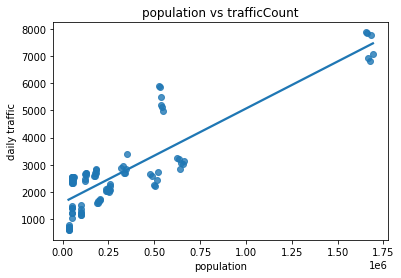

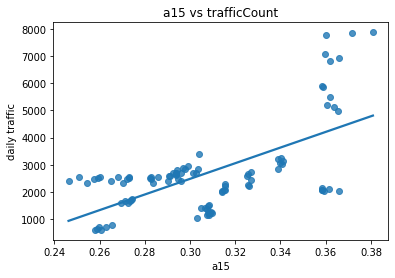

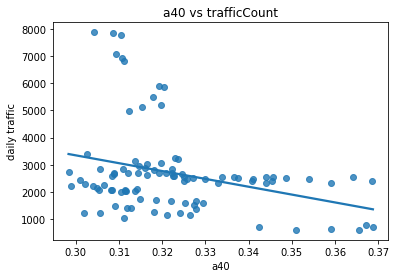

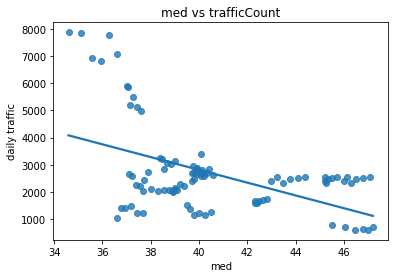

In [46]:
cols = ['population','a15','a40','med']
X = pop_tra[cols]
for column in X.columns:
    plt.figure()
    sns.regplot(x=X[column], y=Y, ci=None)
    plt.title(f'{column} vs trafficCount')
    plt.xlabel(f'{column}')
    plt.ylabel('daily traffic')

y and x show exponential relationship.

In [91]:
target_column = 'trafficCount'

M = pop_tra.copy()
M['exp15'] = M['a15'].apply(lambda x: math.exp(x))
M['exp40'] = M['a40'].apply(lambda x: math.exp(x))
M['expMed'] = M['med'].apply(lambda x: math.exp(x))
M2 = M

cols = ['population','exp15','exp40','expMed']

M = spark.createDataFrame(M[[target_column]+cols])
assembler = VectorAssembler(inputCols=cols, outputCol="features")
M = assembler.transform(M).select(target_column,'features')

In [87]:
M0 = pop_tra.copy()
cols0 = ['population','a15','a40','med']
M0 = spark.createDataFrame(M0[[target_column]+cols0])
assembler = VectorAssembler(inputCols=cols0, outputCol="features")
M0 = assembler.transform(M0).select(target_column,'features')

In [88]:
errs = [[],[]]
epoc = 10

for i in range(epoc):
    
    train, test = M.randomSplit([0.75,0.25])
    lr = LinearRegression(featuresCol="features", labelCol=target_column)
    model = lr.fit(train)
    errs[0].append(model.evaluate(test).rootMeanSquaredError)

for i in range(epoc):
    
    train, test = M0.randomSplit([0.75,0.25])
    lr = LinearRegression(featuresCol="features", labelCol=target_column)
    model = lr.fit(train)
    errs[1].append(model.evaluate(test).rootMeanSquaredError)

for i in errs:
    print(sum(i)/epoc)

23/10/20 18:13:24 WARN Instrumentation: [db6801fd] regParam is zero, which might cause numerical instability and overfitting.
23/10/20 18:13:25 WARN Instrumentation: [347ff819] regParam is zero, which might cause numerical instability and overfitting.
23/10/20 18:13:26 WARN Instrumentation: [40d6f003] regParam is zero, which might cause numerical instability and overfitting.
23/10/20 18:13:27 WARN Instrumentation: [66f0fd15] regParam is zero, which might cause numerical instability and overfitting.
23/10/20 18:13:29 WARN Instrumentation: [2d645bf9] regParam is zero, which might cause numerical instability and overfitting.
23/10/20 18:13:30 WARN Instrumentation: [c457c066] regParam is zero, which might cause numerical instability and overfitting.
23/10/20 18:13:31 WARN Instrumentation: [08fee88b] regParam is zero, which might cause numerical instability and overfitting.
23/10/20 18:13:32 WARN Instrumentation: [4b11f521] regParam is zero, which might cause numerical instability and overf

801.8660166177048
835.265924444761


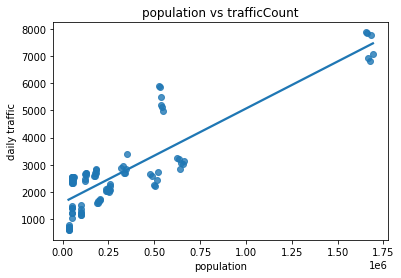

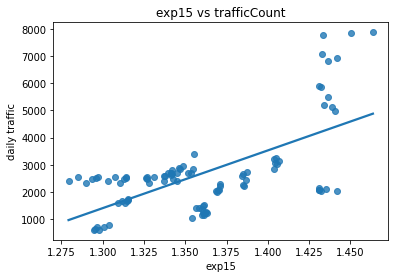

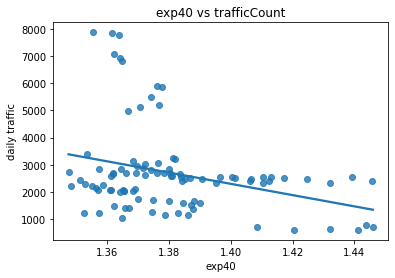

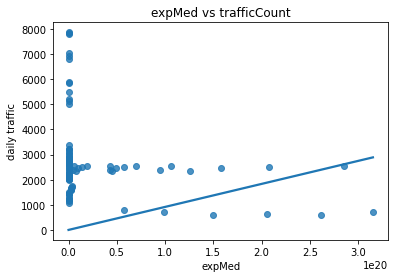

In [96]:
cols = ['population','exp15','exp40','expMed']
X = M2[cols]
Y = pop_tra["trafficCount"]

for column in X.columns:
    plt.figure()
    sns.regplot(x=X[column], y=Y, ci=None)
    plt.title(f'{column} vs trafficCount')
    plt.xlabel(f'{column}')
    plt.ylabel('daily traffic')